### Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

### Read dataset

In [2]:
data = pd.read_csv("./dataset/twitter_training.csv", names = ['tweetid', 'entity','sentiment','text'])
data_test = pd.read_csv('./dataset/twitter_validation.csv', names = ['tweetid','entity','sentiment','text'])
data.head()

,tweetid,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetid    74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [4]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetid    1000 non-null   int64 
 1   entity     1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


## Data cleaning

### Count values of sentiment

In [5]:
data['sentiment'].value_counts()

sentiment
Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

### Drop duplicate and drop null data

In [6]:
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)
data_test.dropna(inplace=True)

### Remove value 'Irrelevant' in sentiment

In [7]:
data.drop(data[data['sentiment'] == 'Irrelevant'].index, inplace=True)
data_test.drop(data_test[data_test['sentiment'] == 'Irrelevant'].index, inplace=True)

In [8]:
data.reset_index(inplace=True)
data_test.reset_index(inplace=True)

### Count chart values in label sentiment

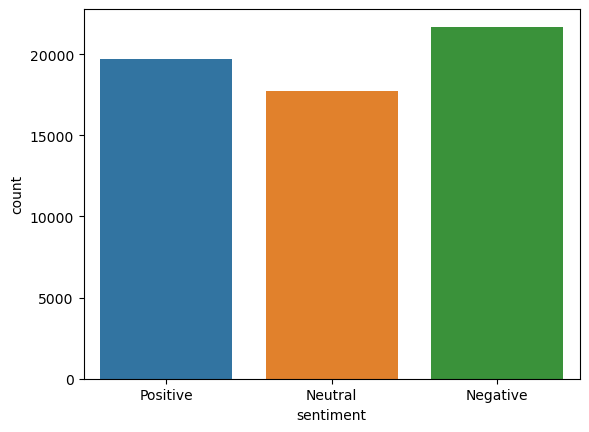

In [9]:
sns.countplot(x='sentiment', data=data)
plt.show()

## Data preprocessing

### Data modeling

In [10]:
X_origin = data['text']
y_label = data['sentiment']
X_test_origin = data_test['text']
y_test_label = data_test['sentiment']

### Import library preprocessing X and y

In [12]:
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from keras import models, layers
#from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical as keras_to_categorical
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping


In [13]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/testvagrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/testvagrant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/testvagrant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/testvagrant/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Label Encoder for label sentiment

In [14]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_label)
y_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(y_mapping)

{'Negative': 0, 'Neutral': 1, 'Positive': 2}


In [15]:
label_encoder.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [16]:
import pickle
# saving
with open('./label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Replace text with some text have character to text

In [19]:
replace_list = {
    r"i'm": 'i am',
    r"im": 'i am',
    r"'re": ' are',
    r"let’s": 'let us',
    r"'s":  ' is',
    r"'ve": ' have',
    r"can't": 'can not',
    r"cannot": 'can not',
    r"shan’t": 'shall not',
    r"n't": ' not',
    r"'d": ' would',
    r"'ll": ' will',
    r"'scuse": 'excuse',
    ',': ' ,',
    '.': ' .',
    '!': ' !',
    '?': ' ?',
    '\s+': ' '
}

### Clean text with replace text and remove some character

In [20]:
def clean_text(text):
    # Replace text
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    # lowercase
    text = text.lower()
    # Text in square brackets
    text = re.sub('\[.*?\]', '', text)
    # link
    text = re.sub('https?://\S+|www\.\S+', '', text)
    # Punctuation
    text = re.sub('[^a-zA-Z0-9\s]+', '', text)
    # Words containing numbers
    text = re.sub('\w*\d\w*', '', text)
    # Stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)
    # Extra whitespace
    text = re.sub('\s+', ' ', text).strip()
    words = nltk.word_tokenize(text)

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in words:
        # Determine POS
        pos_tag = nltk.pos_tag([word])[0][1]
        if pos_tag.startswith('V'):  # Verb
            lemma = lemmatizer.lemmatize(word, wordnet.VERB)
        elif pos_tag.startswith('N'):  # Noun
            lemma = lemmatizer.lemmatize(word, wordnet.NOUN)
        elif pos_tag.startswith('J'):  # ADJ
            lemma = lemmatizer.lemmatize(word, wordnet.ADJ)
        elif pos_tag.startswith('R'):  # ADV
            lemma = lemmatizer.lemmatize(word, wordnet.ADV)
        else:
            lemma = word
        lemmatized_words.append(lemma)

    text = ' '.join(lemmatized_words)
    return text

X_clean = X_origin.apply(lambda p: clean_text(p))
X_test_clean = X_test_origin.apply(lambda p : clean_text(p))

### Vectorizing data

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_words = 10000
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_clean)
X = tokenizer.texts_to_sequences(X_clean)
X_test = tokenizer.texts_to_sequences(X_test_clean)
X= pad_sequences(X, maxlen = 500)
X_test = pad_sequences(X_test, maxlen = 500)

In [22]:
import pickle
# saving
with open('./tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Data Prediction

### Train_test_split X and y

In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, random_state=42)

### Deep learning LSTM model

In [24]:
model = models.Sequential([
    layers.Embedding(input_dim = max_words, output_dim = 128, input_length = 500),
    layers.SpatialDropout1D(0.3),
    layers.LSTM(128, dropout = 0.3, recurrent_dropout = 0.3),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation = 'softmax'),
])
early_stopping = EarlyStopping(monitor='loss', patience=2)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid,y_valid),
    epochs = 20,
    batch_size = 512,
    callbacks=[early_stopping],
)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4610 - loss: 1.0226 - val_accuracy: 0.7159 - val_loss: 0.6883
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 307s 4s/step - accuracy: 0.7475 - loss: 0.6257 - val_accuracy: 0.7775 - val_loss: 0.5568
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8101 - loss: 0.4852 - val_accuracy: 0.7770 - val_loss: 0.5548
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8271 - loss: 0.4444 - val_accuracy: 0.8141 - val_loss: 0.4685
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8564 - loss: 0.3677 - val_accuracy: 0.8294 - val_loss: 0.4301
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8740 - loss: 0.3240 - val_accuracy: 0.8353 - val_loss: 0.4136
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.8837 - loss: 0.2890 - val_accuracy: 0.8442 - val_loss: 0.4016
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8936 - loss: 0.2684 - val_accuracy: 0.8442 - v

### Save and load model LSTM

In [26]:
model.save('./model_keras/lstm_final.h5')

In [41]:
model = models.load_model('./model_keras/lstm_final.h5')

### Plotting accuracy and loss

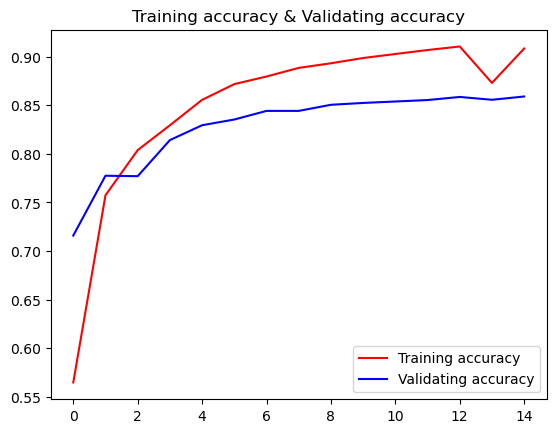

In [42]:
history_ = history.history
acc, val_acc = history_["accuracy"], history_["val_accuracy"]
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validating accuracy')
plt.title('Training accuracy & Validating accuracy')
plt.legend()

plt.show()

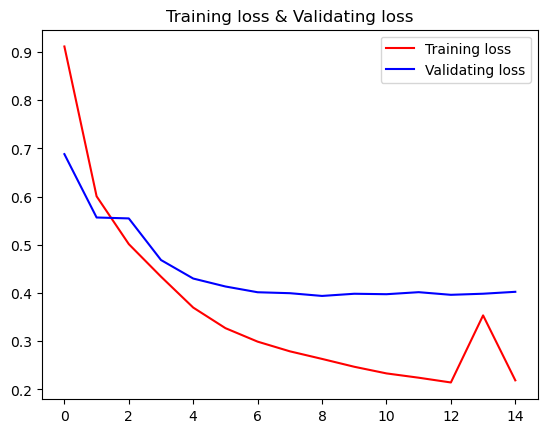

In [43]:
train_loss, val_loss = history_["loss"], history_["val_loss"]
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validating loss')
plt.title('Training loss & Validating loss')
plt.legend()

plt.show()

### Machine learning model

GausianNaiveBayes

In [30]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes.score(X_valid, y_valid)

0.37422192151556155

DecisionTree

In [31]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_valid, y_valid)

0.5666441136671178

RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_valid, y_valid)

0.6579161028416779

## Test with data_test

In [33]:
predict_test = model.predict(X_test)
predicted_labels = np.argmax(predict_test,axis=1)
y_predict = label_encoder.inverse_transform(predicted_labels)

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step


### DataFrame for prediction and y_test

In [34]:
predict_df = pd.DataFrame({
    'Prediction':y_predict,
    'y_test':y_test_label,
})
predict_df.head(10)

,Prediction,y_test
0,Neutral,Neutral
1,Negative,Negative
2,Negative,Negative
3,Neutral,Neutral
4,Negative,Negative
5,Positive,Positive
6,Positive,Positive
7,Positive,Positive
8,Negative,Negative
9,Positive,Positive


### Export DataFrame to File CSV

In [1]:
#predict_df.to_csv('./dataset/twitter_sentiment_analysis/prediction.csv')


In [2]:
import os
predict_df.to_csv('./dataset/prediction.csv')


NameError: name 'predict_df' is not defined

### Test with new data

In [37]:
txt_test = ["This game is so bad man", "I didn't like this game at all"]
txt_test = tokenizer.texts_to_sequences(txt_test)
txt_test = pad_sequences(txt_test, maxlen = 500)

predict = model.predict(txt_test)
predicted_labels = np.argmax(predict, axis=1)
prediction = label_encoder.inverse_transform(predicted_labels)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
['Negative' 'Negative']


In [38]:
txt_test.shape

(2, 500)

In [39]:
np.round(predict, 2)

array([[0.96, 0.01, 0.03],
       [0.48, 0.18, 0.34]], dtype=float32)

In [40]:
prediction

array(['Negative', 'Negative'], dtype=object)